# Test 11
Chirality with Molecular Dynamics

Generate all Final States using MD (Ramp + Evolution)

Getting the chirality stuff from all of the final states.

Getting complementary order parameter.

Averaging

In [105]:
import os
import sys

import numpy as np
import pandas as pd
import random
from math import isclose

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore some messages from pandas

from tqdm import tqdm
from IPython.display import clear_output

import matplotlib.pyplot as plt

sys.path.insert(0, '../icenumerics/')
import icenumerics as ice

from auxiliary import *
from montecarlo_tools import *
from chirality_tools import *

ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.grid'] = True


## Simulation

In [3]:
def get_md_colloid(angle):
    sp = ice.spins()

    # Initialize some parameters
    trapSep = 10*ureg.um
    particleRadius = 5*ureg.um
    totalTime = 120*ureg.s

    #L = trapSep+4*(particleRadius+.5*ureg.um)*np.cos(np.pi/4)
    L = 30*ureg.um
    N = 10

    # Create simulation objects
    sp.create_lattice("square",[N,N],lattice_constant=L, border="periodic")

    particle = ice.particle(radius = particleRadius,
                susceptibility = 0.0576,
                diffusion = 0.125*ureg.um**2/ureg.s,
                temperature = 300*ureg.K,
                density = 1000*ureg.kg/ureg.m**3)

    trap = ice.trap(trap_sep = trapSep,
                height = 4*ureg.pN*ureg.nm,
                stiffness = 1e-3*ureg.pN/ureg.nm)

    col = ice.colloidal_ice(sp, particle, trap,
                            height_spread = 0, 
                            susceptibility_spread = 0.1,
                            periodic = True)

        
    col.randomize()
    col.region = np.array([[0,0,-3*(particleRadius/L/N).magnitude],[1,1,3*(particleRadius/L/N).magnitude]])*N*L

    framespersec = 20*ureg.Hz;
    dt = 10*ureg.ms

    world = ice.world(
            field = 8*ureg.mT,
            temperature = 300*ureg.K,
            dipole_cutoff = 200*ureg.um,
            boundaries=['p', 'p', 'p'])


    col.simulation(world,
                name = "test",
                include_timestamp = False,
                targetdir = r".",
                framerate = framespersec,
                timestep = dt,
                run_time = totalTime,
                output = ["x","y","z","mux","muy","muz"])

    # Field

    angle = np.round(angle*np.pi/180,decimals=6)
    col.sim.field.fieldx = f"v_Bmag*sin({angle})*time/60e6*(time<60e6)+v_Bmag*sin({angle})*(time>=60e6)"
    col.sim.field.fieldy = "0"
    col.sim.field.fieldz = f"v_Bmag*cos({angle})*time/60e6*(time<60e6)+v_Bmag*cos({angle})*(time>=60e6)"

    

    col.run_simulation();

    col.load_simulation()

    return col

In [4]:
angle_completed = os.listdir("../data/test11/angles/")
angles = [angle for angle in range(0,90+1,1) if str(angle) not in angle_completed]
angle_select = angles[:]

In [ ]:
angle_step = 5
runs = 10
data_path = "../data/test11/angles/"
for angle in angle_select:
    print(f"===== Angle {angle} =====")

    main_angle_path = data_path + str(angle)
    trj_path = main_angle_path + "/trj/"
    ctrj_path = main_angle_path + "/ctrj/"

    try:
        os.mkdir(main_angle_path)
        os.mkdir(trj_path)
        os.mkdir(ctrj_path)
    except:
        pass

    for i in range(1,runs+1):
        print(f"- Realization {i} -")
        
        col = get_md_colloid(angle)

        filename = f"trj{i}.csv"
        col.trj.to_csv(trj_path + filename)
        print("Saved trj")

        filename = f"ctrj{i}.csv"
        trj = ice.get_ice_trj(col.trj, bounds = col.bnd)
        trj.to_csv(ctrj_path + filename)
        print("Saved ctrj")
        
    clear_output(wait=True)

## Sanity Check

In [ ]:
trj_raw = trj = pd.read_csv("../data/test11/angles/60/trj/trj10.csv", index_col=[0,1])
ctrj_raw = pd.read_csv("../data/test11/angles/60/ctrj/ctrj10.csv", index_col=[0,1])

fig, ax = plt.subplots(1,3,figsize=(9,2),dpi=150)

ax[0].plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"mux"]))
ax[1].plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"muy"]))
ax[2].plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"muz"]))

# Chirality

In [7]:
# General information
trapSep = 10*ureg.um
particleRadius = 5*ureg.um
totalTime = 120*ureg.s

    #L = trapSep+4*(particleRadius+.5*ureg.um)*np.cos(np.pi/4)
L = 30*ureg.um
N = 10

    # Create simulation objects
particle = ice.particle(radius = particleRadius,
            susceptibility = 0.0576,
            diffusion = 0.125*ureg.um**2/ureg.s,
            temperature = 300*ureg.K,
            density = 1000*ureg.kg/ureg.m**3)

trap = ice.trap(trap_sep = trapSep,
            height = 4*ureg.pN*ureg.nm,
            stiffness = 1e-3*ureg.pN/ureg.nm)


params = {
    "particle" : particle,
    "trap" : trap,
    "particle_radius" : particleRadius,
    "lattice_constant" : L,
    "size" : N
}

In [ ]:
angles_completed = np.sort([int(a) for a in os.listdir("../data/test11/angles")])
angles_completed

In [ ]:
phi = []
runs = 10

for angle in tqdm(angles_completed):
    clear_output(wait=True)

    angle_chirs = [get_chirality_on_realization(params,angle,i) for i in range(1,runs+1)]

    phi.append(angle_chirs)

phi

In [ ]:
phi_df = pd.DataFrame(phi)
phi_df.to_csv("../data/test11/chirality.csv")
phi_df

# Complementary order parameter

$$
    Q = \sum_{i,j} (-1)^{i+j}q_{ij}
$$

In [31]:
for angle in tqdm(range(0,90+1)):
    for realization in range(1,10+1):
        angle_path = f"../data/test11/angles/{angle}/ctrj/ctrj{realization}.csv"

        try:
            os.mkdir(f"../data/test11/vertices/{angle}")
        except:
            pass

        vertex_path = f"../data/test11/vertices/{angle}/vertices{realization}.csv"
        try:
            vertices = get_vertices_last_frame(angle_path, last_frame=2399)
        except:
            vertices = get_vertices_last_frame(angle_path, last_frame=2399-1)


        vertices.to_csv(vertex_path)

    clear_output(wait=True)

100%|██████████| 58/58 [24:13<00:00, 25.07s/it]


In [108]:
psi= []
for angle in tqdm(range(90+1)):
    results = [get_charge_order_on_realization(params, angle,realization) for realization in range(1,10+1) ]
    psi.append(results)

100%|██████████| 91/91 [00:35<00:00,  2.58it/s]


In [111]:
psi_df = pd.DataFrame(psi)
psi_df.to_csv("../data/test11/charges.csv")

#  Importing data and ploting

In [130]:
angles_completed = np.sort([int(a) for a in os.listdir("../data/test11/angles")])
phi_df = pd.read_csv("../data/test11/chirality.csv",index_col=0).applymap(np.abs)
psi_df = pd.read_csv("../data/test11/charges.csv",index_col=0).applymap(np.abs)

In [133]:
phi_means = phi_df.mean(axis=1).to_list()
phi_sigmas = phi_df.var(axis=1).to_list()

psi_means = psi_df.mean(axis=1).to_list()
psi_sigmas = psi_df.var(axis=1).to_list()


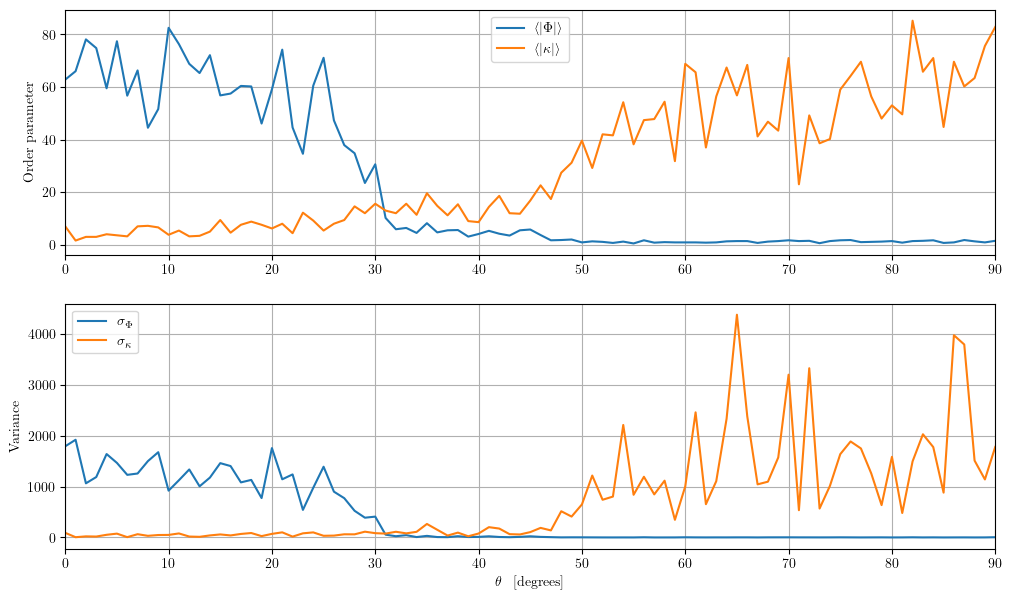

In [152]:
fig, axes = plt.subplots(2,1,figsize=(12,7))

ax = axes[0]
ax.plot(angles_completed,phi_means, label = "$\\langle |\\Phi|\\rangle$")
ax.plot(angles_completed,psi_means, label = "$\\langle |\\kappa|\\rangle$")
ax.set_ylabel("Order parameter")
ax.set_xlim(0,90)
ax.legend()

ax = axes[1]

ax.plot(angles_completed,phi_sigmas, label="$\\sigma_\\Phi$")
ax.plot(angles_completed,psi_sigmas, label="$\\sigma_\\kappa$")

ax.set_xlabel("$\\theta$ \, [degrees]")
ax.set_ylabel("Variance")

ax.legend()

ax.set_xlim(0,90)

plt.show()

fig.savefig("../data/test11/order_parameters.png",dpi=300)